
# Churn – Regresión Logística (Notebook 01)

Este notebook entrena y evalúa **Regresión Logística** para predecir la variable binaria **`exited`** sobre el dataset procesado `Churn_Modelling-ETL 2.csv`.

Incluye:
- Pipeline de preprocesamiento (OneHot + StandardScaler)
- Train/Test Split (estratificado)
- Métricas de **clasificación**: Accuracy, Precision, Recall, F1, ROC-AUC, Matriz de Confusión
- Gráficas con **Seaborn**: matriz de confusión, curva ROC, curva Precision–Recall y barras de métricas


In [1]:

# Config y librerías
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve
)

sns.set(style="whitegrid")
BASE = Path("../../")
DATA = BASE / "Churn_Modelling-ETL 2.csv"


In [2]:

# Carga y preparación
df = pd.read_csv(DATA)

target_col = "exited" if "exited" in df.columns else "Exited"
assert target_col in df.columns, "No se encontró la columna objetivo ('exited' o 'Exited')."

drop_ids = [c for c in ["row_number", "customer_id", "surname", "RowNumber", "CustomerId", "Surname"] if c in df.columns]
X = df.drop(columns=[target_col] + drop_ids, errors="ignore")
y = df[target_col].astype(int)

cat_cols = [c for c in X.columns if X[c].dtype == "object"]
num_cols = [c for c in X.columns if c not in cat_cols]

X.head(), y.value_counts(normalize=True)


(   credit_score  gender  age  tenure_years  account_balance  num_products  \
 0           619  Female   42             2             0.00             1   
 1           608  Female   41             1         83807.86             1   
 2           502  Female   42             8        159660.80             3   
 3           699  Female   39             1             0.00             2   
 4           850  Female   43             2        125510.82             1   
 
    has_credit_card  is_active_member  estimated_salary country  ...  \
 0             True              True         101348.88  France  ...   
 1            False              True         112542.58   Spain  ...   
 2             True             False         113931.57  France  ...   
 3            False             False          93826.63  France  ...   
 4             True              True          79084.10   Spain  ...   
 
    days_since_last_login  device_type  num_transactions_app  \
 0                     72       

In [3]:
# Pipeline: preprocesamiento + modelo
preprocess = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols),
])

logreg = LogisticRegression(max_iter=1000, random_state=42)

pipe = Pipeline([
    ("prep", preprocess),
    ("clf", logreg),
])


In [4]:
# Train/Test split y entrenamiento
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

pipe.fit(X_train, y_train)

# Predicciones
y_prob = pipe.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.50).astype(int)

# Métricas
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred, zero_division=0)
f1   = f1_score(y_test, y_pred, zero_division=0)
auc  = roc_auc_score(y_test, y_prob)
cm   = confusion_matrix(y_test, y_pred)

print(f"Accuracy     : {acc:.4f}")
print(f"Precision(1) : {prec:.4f}")
print(f"Recall(1)    : {rec:.4f}")
print(f"F1(1)        : {f1:.4f}")
print(f"ROC-AUC      : {auc:.4f}")
print("Matriz de confusión:\n", cm)

metrics_df = pd.DataFrame({
    "Métrica": ["Accuracy","Precision","Recall","F1","ROC-AUC"],
    "Valor":   [acc, prec, rec, f1, auc]
})
metrics_df


Accuracy     : 0.8324
Precision(1) : 0.7083
Recall(1)    : 0.3006
F1(1)        : 0.4221
ROC-AUC      : 0.8067
Matriz de confusión:
 [[1928   63]
 [ 356  153]]


,Métrica,Valor
0,Accuracy,0.832400
1,Precision,0.708333
2,Recall,0.300589
3,F1,0.422069
4,ROC-AUC,0.806696


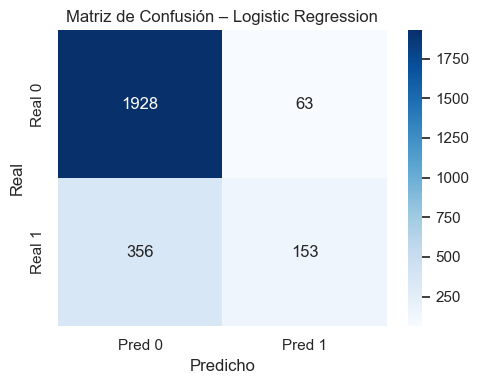

In [5]:

# Gráfica: Matriz de Confusión (Seaborn)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred 0","Pred 1"], yticklabels=["Real 0","Real 1"])
plt.title("Matriz de Confusión – Logistic Regression")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.tight_layout()
plt.show()


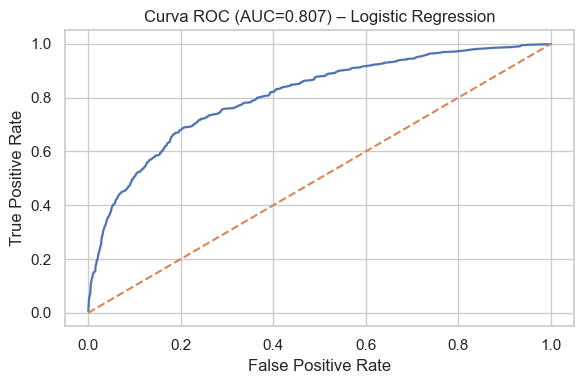

In [6]:

# Gráfica: Curva ROC (Seaborn/Matplotlib)
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,4))
sns.lineplot(x=fpr, y=tpr)
sns.lineplot(x=[0,1], y=[0,1], linestyle="--")
plt.title(f"Curva ROC (AUC={auc:.3f}) – Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.tight_layout()
plt.show()


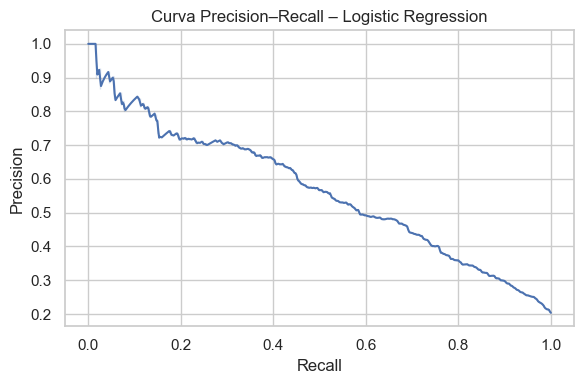

In [7]:

# Gráfica: Curva Precision–Recall (Seaborn)
precisions, recalls, _ = precision_recall_curve(y_test, y_prob)
plt.figure(figsize=(6,4))
sns.lineplot(x=recalls, y=precisions)
plt.title("Curva Precision–Recall – Logistic Regression")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.tight_layout()
plt.show()


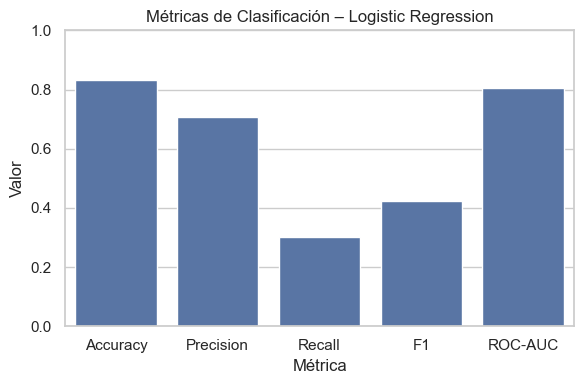

In [8]:

# Gráfica: Barras de métricas (Seaborn)
plt.figure(figsize=(6,4))
sns.barplot(data=metrics_df, x="Métrica", y="Valor")
plt.ylim(0,1)
plt.title("Métricas de Clasificación – Logistic Regression")
plt.tight_layout()
plt.show()
